In [1]:
from functions import *

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns

## Load data

### Choose inputs

In [73]:
W = 256
source_path = '../data/preprocessed/'
data_paths = ['lst', 'ndvi', 'wt', 'masked','discharge']#, 'wt_interpolated']
dir_paths = [os.path.join(source_path,p) for p in data_paths]
all_dir_paths = {k:[] for k in data_paths}

for i,dir_p in enumerate(dir_paths):
    for subdir, dirs,files in os.walk(dir_p):
        if subdir != dir_p and not subdir.endswith('masked'): #and rivers_count < max_rivers:
            all_dir_paths[data_paths[i]].append(subdir)
        elif subdir.endswith('masked'):
            all_dir_paths['masked'].append(subdir)
        elif subdir.endswith('discharge'):
            all_dir_paths['discharge'].append(subdir)


all_dir_paths    

{'lst': ['../data/preprocessed/lst/Wasserfallenbach',
  '../data/preprocessed/lst/Eibachli',
  '../data/preprocessed/lst/Bisse-Neuf',
  '../data/preprocessed/lst/LaVenoge_shapefile',
  '../data/preprocessed/lst/le_boiron2',
  '../data/preprocessed/lst/I_Custiell',
  '../data/preprocessed/lst/La_Paudeze',
  '../data/preprocessed/lst/Zauggenbach',
  '../data/preprocessed/lst/Aletenbach',
  '../data/preprocessed/lst/Alplibach',
  '../data/preprocessed/lst/Plattenbach',
  '../data/preprocessed/lst/swissTLMboiron',
  '../data/preprocessed/lst/LaBroye_shapefile'],
 'ndvi': ['../data/preprocessed/ndvi/Wasserfallenbach',
  '../data/preprocessed/ndvi/Eibachli',
  '../data/preprocessed/ndvi/Bisse-Neuf',
  '../data/preprocessed/ndvi/LaVenoge_shapefile',
  '../data/preprocessed/ndvi/le_boiron2',
  '../data/preprocessed/ndvi/I_Custiell',
  '../data/preprocessed/ndvi/La_Paudeze',
  '../data/preprocessed/ndvi/Zauggenbach',
  '../data/preprocessed/ndvi/Aletenbach',
  '../data/preprocessed/ndvi/Alpliba

In [78]:
total_data = {}
total_times = {}
filter_river = None
for k,v in all_dir_paths.items():
    if k != 'discharge':
        if k == 'lst' or k == 'masked':
            list_rgb = [True]*len(v)
        else:
            list_rgb = [False]*len(v)
        
        if filter_river != None:
            v = [v[filter_river]]
        print('getting data for path',v) 
        data, times = load_data(v,W,list_rgb)
        
        #d = [item for sublist in data.values() for item in sublist]
        total_data[k] = np.concatenate(list(data.values()), axis=0)
        total_times[k] = times
        print(k,':' ,total_data[k].shape)
    else:
        print('hola')
        for file in os.listdir(v[0]):
            file_path = os.path.join(v[0], file)
            r,m = load_raster(file_path, False)
            discharge = resize_image(r, W,W)
            discharge_input = np.tile(discharge, (len(all_dir_paths['lst']), 1, 1))


getting data for path ['../data/preprocessed/lst/Wasserfallenbach', '../data/preprocessed/lst/Eibachli', '../data/preprocessed/lst/Bisse-Neuf', '../data/preprocessed/lst/LaVenoge_shapefile', '../data/preprocessed/lst/le_boiron2', '../data/preprocessed/lst/I_Custiell', '../data/preprocessed/lst/La_Paudeze', '../data/preprocessed/lst/Zauggenbach', '../data/preprocessed/lst/Aletenbach', '../data/preprocessed/lst/Alplibach', '../data/preprocessed/lst/Plattenbach', '../data/preprocessed/lst/swissTLMboiron', '../data/preprocessed/lst/LaBroye_shapefile']
lst : (119, 256, 256, 3)
getting data for path ['../data/preprocessed/ndvi/Wasserfallenbach', '../data/preprocessed/ndvi/Eibachli', '../data/preprocessed/ndvi/Bisse-Neuf', '../data/preprocessed/ndvi/LaVenoge_shapefile', '../data/preprocessed/ndvi/le_boiron2', '../data/preprocessed/ndvi/I_Custiell', '../data/preprocessed/ndvi/La_Paudeze', '../data/preprocessed/ndvi/Zauggenbach', '../data/preprocessed/ndvi/Aletenbach', '../data/preprocessed/ndv

TypeError: expected str, bytes or os.PathLike object, not list

In [79]:
lst = total_data['lst']
ndvi = total_data['ndvi']
data_targets = total_data['wt']
#wt_stations = data[dir_paths[3]]
print('inputs shape:', lst.shape,ndvi.shape)
print('targets shape:', data_targets.shape)

inputs shape: (119, 256, 256, 3) (119, 256, 256)
targets shape: (119, 256, 256)


In [118]:
'''for i in range(lst.shape[0]):
    fig, axes = plt.subplots(1,3, figsize=(10,5))
    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))
    axes[0].set_title('lst')

    axes[1].imshow(ndvi[i])
    axes[1].set_title('ndvi')

    axes[2].imshow(data_targets[i])
    axes[2].set_title('wt')

    if total_times['lst'][0][i] != total_times['ndvi'][0][i] or total_times['lst'][0][i] != total_times['wt'][0][i] or total_times['ndvi'][0][i] != total_times['wt'][0][i]:
        print('Time mismatch')

    plt.suptitle(f"For time {total_times['lst'][0][0]}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()'''


'for i in range(lst.shape[0]):\n    fig, axes = plt.subplots(1,3, figsize=(10,5))\n    axes[0].imshow(np.clip(lst[i]*(6/255), 0, 1))\n    axes[0].set_title(\'lst\')\n\n    axes[1].imshow(ndvi[i])\n    axes[1].set_title(\'ndvi\')\n\n    axes[2].imshow(data_targets[i])\n    axes[2].set_title(\'wt\')\n\n    if total_times[\'lst\'][0][i] != total_times[\'ndvi\'][0][i] or total_times[\'lst\'][0][i] != total_times[\'wt\'][0][i] or total_times[\'ndvi\'][0][i] != total_times[\'wt\'][0][i]:\n        print(\'Time mismatch\')\n\n    plt.suptitle(f"For time {total_times[\'lst\'][0][0]}", fontsize=16)\n    plt.tight_layout()\n    plt.subplots_adjust(top=0.9)\n    plt.show()'

In [80]:
inputs = 'lst, ndvi' #'lst+ndvi' for ndvi inputs

Convert inputs to gray images

'''masked_gray_inputs = []
gray_inputs = []
for i in range(masked_inputs.shape[0]):
  masked_img_rgb = masked_inputs[i]
  masked_img_gray = np.dot(masked_img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  masked_gray_inputs.append(masked_img_gray)

  img_rgb = data_inputs[i]
  img_gray = np.dot(img_rgb[...,:3], [0.2989, 0.5870, 0.1140]) # turn to gray image, calculate the weighted average of each channel contribution
  gray_inputs.append(img_gray)

masked_gray_inputs = np.array(masked_gray_inputs)
print(masked_gray_inputs.shape)

gray_inputs = np.array(gray_inputs)
print(gray_inputs.shape)'''

Split data

In [81]:
if inputs == 'lst':
    train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(lst, data_targets)
else:
    # Lista de diferentes conjuntos de imágenes a combinar con LST
    additional_images = [ndvi]#, disch_lebroye]  # Añade todas las imágenes adicionales que quieras

    # Expande la dimensión de cada conjunto de imágenes para asegurar que tengan un canal extra
    expanded_images = [np.expand_dims(img, axis=-1) for img in additional_images]  # Cada imagen tendrá shape: (n_samples, 256, 256, 1)

    # Concatenar LST con todas las imágenes adicionales a lo largo del último eje (canales)
    combined_input = np.concatenate([lst] + expanded_images, axis=-1)  # LST (RGB) + todas las imágenes adicionales
    # Shape final: (n_samples, 256, 256, n_channels) donde n_channels depende del número de conjuntos de imágenes

    # Ahora puedes usar 'combined_input' para el resto del procesamiento
    train_input, train_target, validation_input, validation_target, test_input, test_target = split_data(combined_input, data_targets)


In [82]:
print(train_input.shape, train_target.shape, validation_input.shape, validation_target.shape, test_input.shape, test_target.shape)

(97, 256, 256, 4) (97, 256, 256) (11, 256, 256, 4) (11, 256, 256) (11, 256, 256, 4) (11, 256, 256)


## Choose hyperparameters

In [83]:
batch_size = 8
epochs = 50

## CNN simpler

In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def build_simplified_cnn_model(input_shape):
    model = models.Sequential()

    # Capa 1: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001),input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa 2: Convolucional + Activación ReLU + Max Pooling
    model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Capa de aplanamiento
    model.add(layers.Flatten())

    # Capa densa
    model.add(layers.Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)))

    # Capa de salida con activación lineal (para predicciones de temperatura)
    model.add(layers.Dense(256 * 256, activation='linear'))

    # Reshape de la salida a la forma (256, 256)
    model.add(layers.Reshape((256, 256)))

    return model

# Construir el modelo
if len(train_input.shape) == 3:
  input_shape = train_input.shape[1:]+(1,)
else:
  input_shape = train_input.shape[1:]  # Assuming data_inputs is your dataset


In [87]:
simplified_cnn_model = build_simplified_cnn_model(input_shape)
simplified_cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Resumen del modelo
simplified_cnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 254, 254, 16)      592       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 123008)            0         
                                                                 
 dense_6 (Dense)             (None, 64)               

In [88]:
#tf.keras.utils.plot_model(simplified_cnn_model)

In [89]:
history = simplified_cnn_model.fit(train_input, train_target, batch_size=batch_size, epochs=epochs, validation_data=(validation_input, validation_target))

Epoch 1/50


13/13 [==============================] - 1s 90ms/step - loss: 1.3341 - mae: 0.1492 - val_loss: 1.9678 - val_mae: 0.2562
Epoch 2/50
13/13 [==============================] - 1s 74ms/step - loss: 1.2617 - mae: 0.1785 - val_loss: 2.0145 - val_mae: 0.2154
Epoch 3/50
13/13 [==============================] - 1s 70ms/step - loss: 1.2430 - mae: 0.1934 - val_loss: 1.9800 - val_mae: 0.2531
Epoch 4/50
13/13 [==============================] - 1s 71ms/step - loss: 1.2302 - mae: 0.1964 - val_loss: 1.9960 - val_mae: 0.2033
Epoch 5/50
13/13 [==============================] - 1s 70ms/step - loss: 1.2289 - mae: 0.1879 - val_loss: 1.9547 - val_mae: 0.2882
Epoch 6/50
13/13 [==============================] - 1s 70ms/step - loss: 1.2451 - mae: 0.1987 - val_loss: 1.9340 - val_mae: 0.2741
Epoch 7/50
13/13 [==============================] - 1s 70ms/step - loss: 1.2442 - mae: 0.2123 - val_loss: 1.9751 - val_mae: 0.2361
Epoch 8/50
13/13 [==============================] - 1s 77ms/step - loss: 1.2353 - mae: 0.2028 

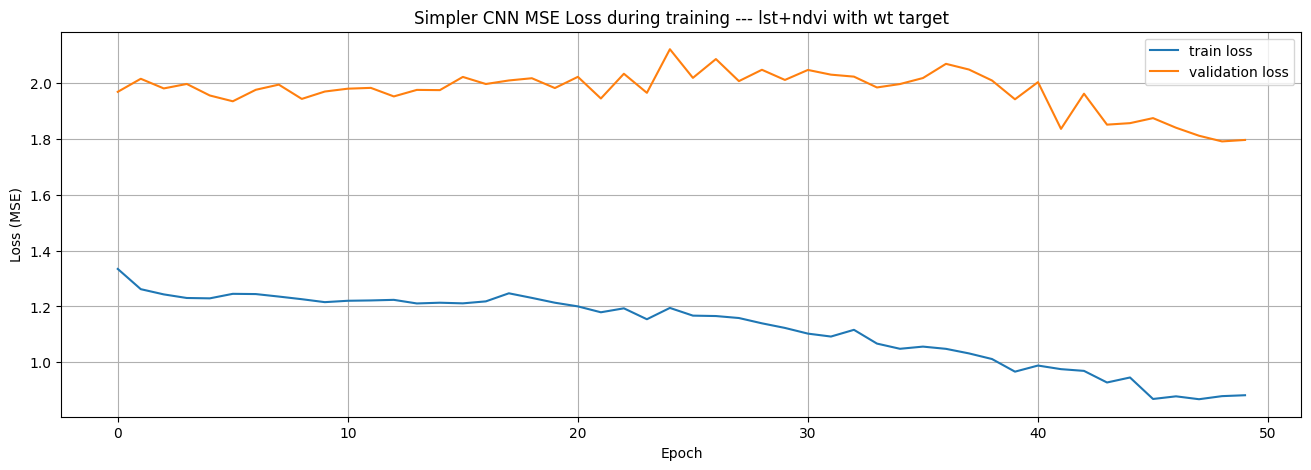

In [90]:
plt.figure(figsize=(16,5))
#plt.clf
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Simpler CNN MSE Loss during training --- lst+ndvi with wt target')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid()
plt.show()

In [91]:
plt.savefig('../plots/cnn.png')

<Figure size 640x480 with 0 Axes>

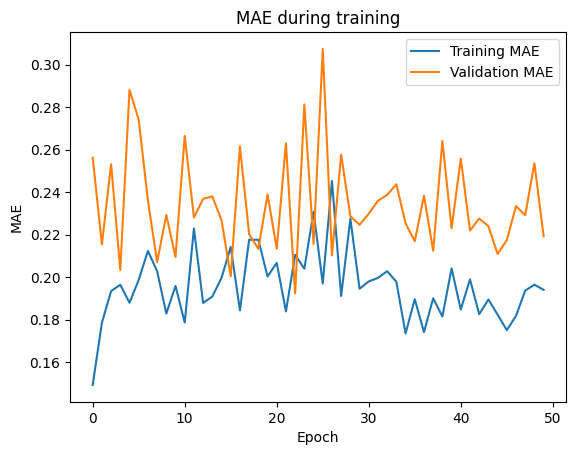

In [92]:
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('MAE during training')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### Validate and test

In [93]:
# Evaluar el modelo en el conjunto de validación
loss, mae = simplified_cnn_model.evaluate(validation_input, validation_target)

print(f'Pérdida (MSE) en validación: {loss}')
print(f'MAE en validación: {mae}')

1/1 [==============================] - 0s 51ms/step - loss: 1.7956 - mae: 0.2192
Pérdida (MSE) en validación: 1.7956149578094482
MAE en validación: 0.21922904253005981


In [94]:
validation_prediction = simplified_cnn_model.predict(validation_input)
test_prediction = simplified_cnn_model.predict(test_input)

1/1 [==============================] - 0s 36ms/step


In [95]:
validation_target_flat = validation_target.reshape(-1)
validation_prediction_flat = validation_prediction.reshape(-1)

test_target_flat = test_target.reshape(-1)
test_prediction_flat = test_prediction.reshape(-1)

In [96]:
val_target_mask = validation_target_flat[validation_target_flat!= 0]
val_pred_mask = validation_prediction_flat[validation_target_flat!= 0]
test_target_mask = test_target_flat[test_target_flat!= 0]
test_pred_mask = test_prediction_flat[test_target_flat!= 0]

Overall results

In [97]:
results = evaluate_model(val_target_mask, val_pred_mask)
print('Validation results')
for k,v in results.items():
  print(k,':',v)

Validation results
MAE : 9.942684
MSE : 231.15279
RMSE : 11.698544
R² : -2.4863509729630358
MAPE (%) : 82.73783922195435
MSE sample-wise : 136.85591


In [98]:
results = evaluate_model(test_target_mask, test_pred_mask)
print('Test results')
for k,v in results.items():
  print(k,':',v)

Test results
MAE : 9.776793
MSE : 108.263725
RMSE : 10.691332
R² : -2.275293465541118
MAPE (%) : 99.64563250541687
MSE sample-wise : 114.30458


Image wise metrics results

In [99]:
c = 0
mean_results = {k:[] for k in results.keys()}
# Loop through each sample and compute the MSE for that sample
for i in range(test_target.shape[0]):
    samples_per_image = test_target.shape[1]*test_target.shape[2]
    # Flatten the true and predicted values for this sample
    y_true_flatten = test_target_flat[c:c+samples_per_image]
    y_true_mask = y_true_flatten[y_true_flatten!= 0]

    y_pred_flatten = test_prediction_flat[c:c+samples_per_image]
    y_pred_mask = y_pred_flatten[y_true_flatten!= 0]

    #print(y_true_flatten.shape,y_pred_flatten.shape)
    # Calculate MSE for this sample
    mse = mean_squared_error(y_true_mask, y_pred_mask)
    res = evaluate_model(y_true_mask, y_pred_mask)

    for k,v in res.items():
      mean_results[k].append(v)


    c += samples_per_image

for key in mean_results:
    mean_results[key] = np.mean(mean_results[key])

print(mean_results)

{'MAE': 7.7778764, 'MSE': 86.99317, 'RMSE': 7.7953753, 'R²': -29342221182427.113, 'MAPE (%)': 103.58976505019449, 'MSE sample-wise': 82.13083}


See what are the areas with more prediction error

In [100]:
validation_prediction[0].shape

(256, 256)

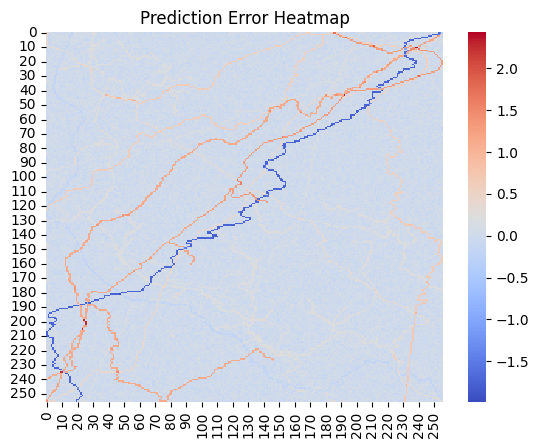

In [101]:
diff = validation_prediction[0] - validation_target[0]
sns.heatmap(diff, cmap='coolwarm')
plt.title('Prediction Error Heatmap')
plt.show()

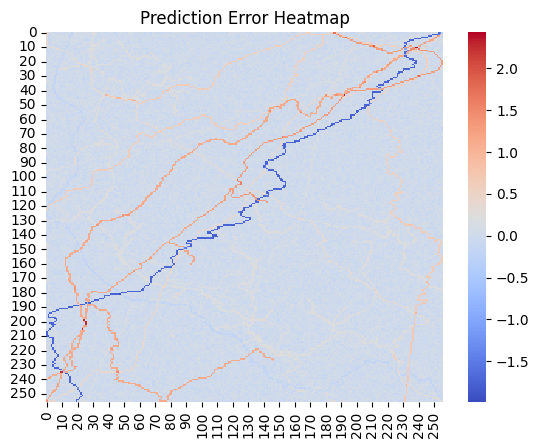

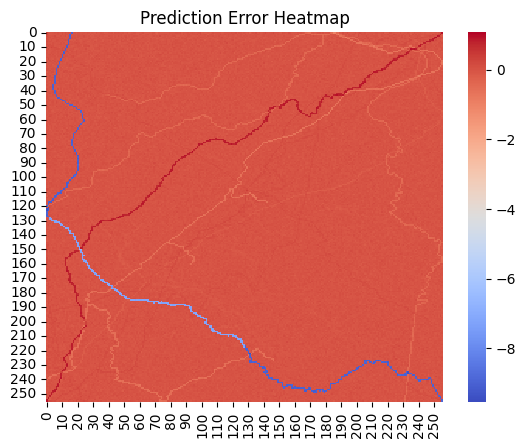

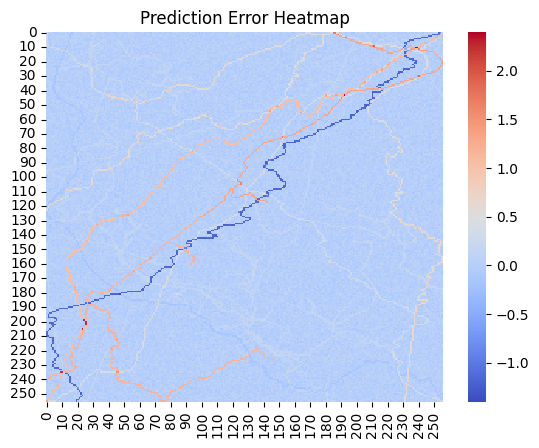

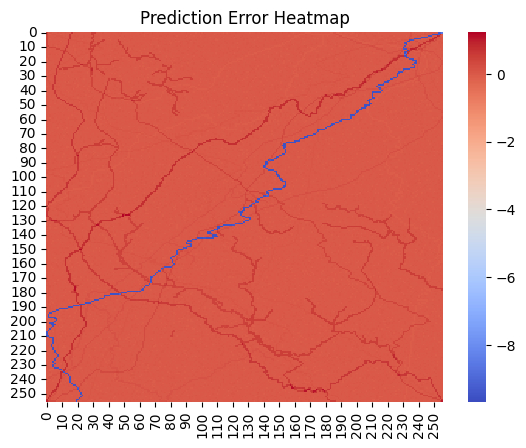

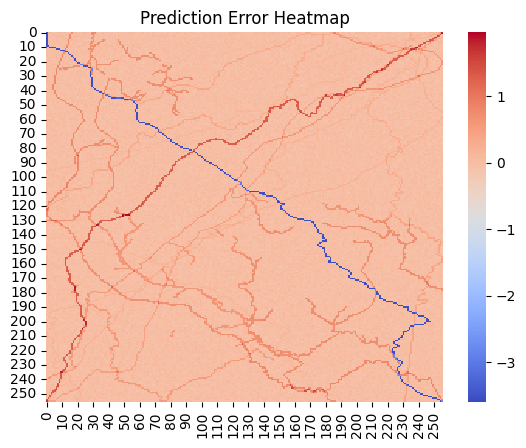

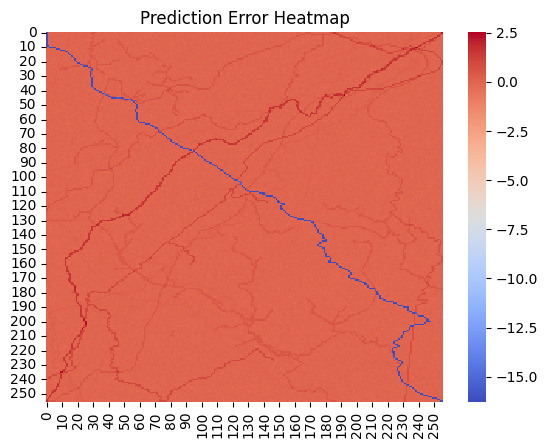

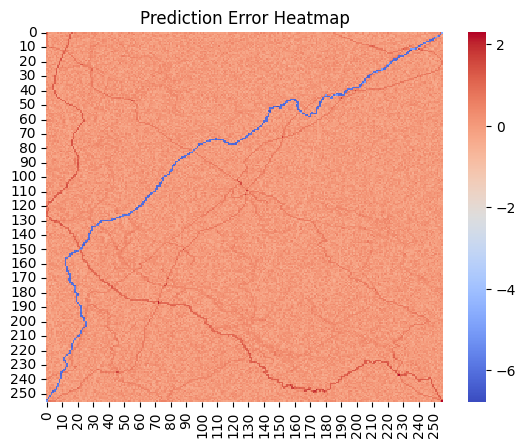

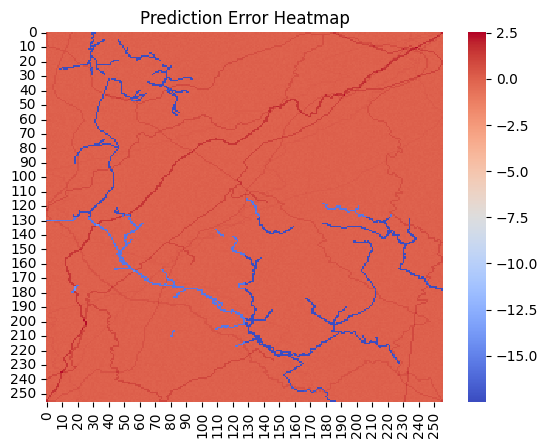

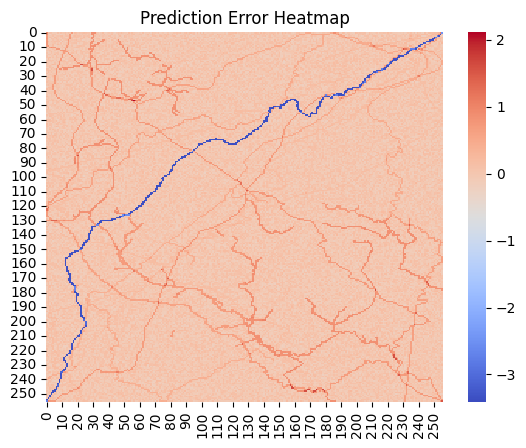

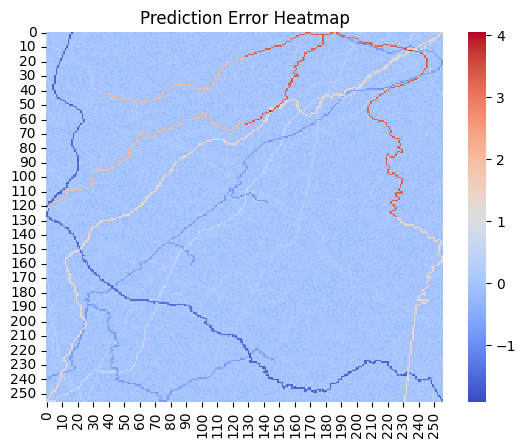

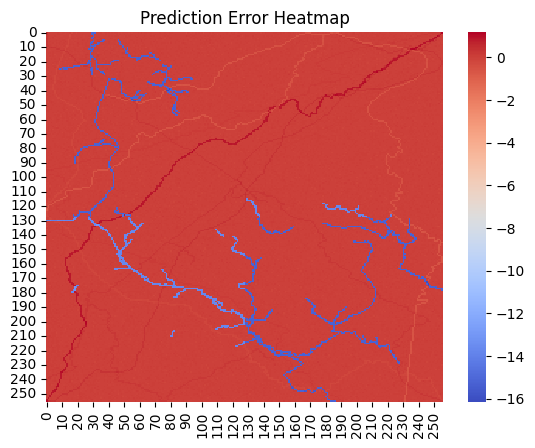

In [102]:
diff = validation_prediction - validation_target
for i in range(diff.shape[0]):
  sns.heatmap(diff[i], cmap='coolwarm')
  plt.title('Prediction Error Heatmap')
  plt.show()

Dispersion graph and histogram of prediction errors

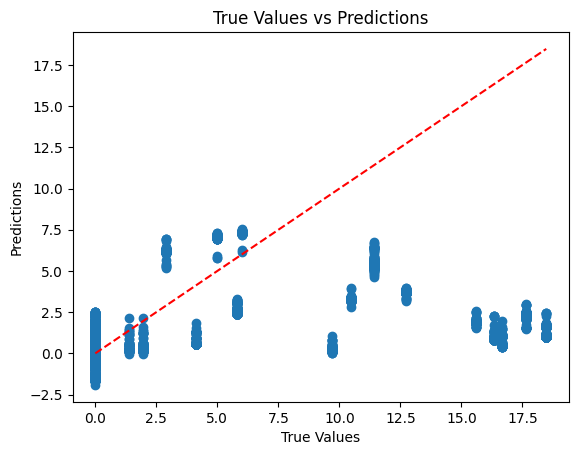

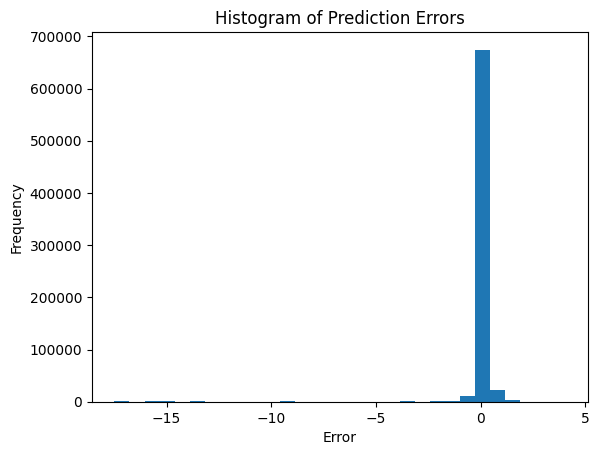

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que y_true son tus valores reales y y_pred son tus predicciones
y_true = validation_target_flat # Valores reales
y_pred = validation_prediction_flat  # Predicciones del modelo

# Visualización
plt.scatter(y_true, y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
plt.title('True Values vs Predictions')
plt.show()

# Histograma de errores
errors = y_pred - y_true
plt.hist(errors, bins=30)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


#### Save model results

In [104]:
model_name = "img_wise_CNN"
details = {'RMSE':mean_results['RMSE'],'Variables':inputs,'Input': '10 rivers', 'Output': 'wt', 'Resolution': W, 'nº samples': len(data_targets), 'Batch size': batch_size, 'Epochs': epochs}

file_path = f"../results/{model_name}_results.xlsx"
save_excel(file_path, details, excel = 'Results')

mean_results['Model'] = model_name
file_path = f"../results/all_results.xlsx"
save_excel(file_path, mean_results, excel = 'Results')